In [1]:
using JuMP
using Ipopt
using CSV
using GraphRecipes, Plots
using LightGraphs
using LinearAlgebra
using SparseArrays
using DataFrames
using Juniper, Alpine

In [2]:
innovations = CSV.File("./innovations.csv",header=1,delim=",") |> DataFrame
mapki = CSV.File("./map-ki.csv",header=1,delim=",") |> DataFrame
compromise = CSV.File("./compromise.csv",header=1,delim=",") |> DataFrame
initial = CSV.File("./initial.csv",header=1,delim=",") |> DataFrame


,k,i,GWP,Theta,Per_Recycl,Per_Comp
,Int64,Int64,Int64,Float64,Float64,Int64
1,0,0,100,0.25,0.12,0


In [3]:
i=5
p=i-4
print(p)

1

In [4]:
function tech_roadmap()
    rdmap=Model(Alpine.Optimizer)
    @variable(rdmap,yk[k=1:nrow(compromise)],Bin)
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise)] ≤ 50)
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise)] ≤ 1)
    @variable(rdmap,yi[i=1:nrow(innovations)],Bin)
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations)] ≤ 50)
    
    @constraint(rdmap, [i=1], sum(yk[k] for k=1:mapki[i,2])==yi[i])
    @constraint(rdmap, [i=2:nrow(mapki)], sum(yk[k] for k=mapki[i-1,2]:mapki[i,2])==yi[i])
    
    @constraint(rdmap, [i=1,k=1:mapki[i,2]], ti[i] ≤ tk[k])
    @constraint(rdmap, [i=2:nrow(mapki),k=mapki[i-1,2]:mapki[i,2]], ti[i] ≤ tk[k])
    
    @constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≥ ti[i])
    @constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≥ tk[k])
    
    @constraint(rdmap, [k=1:nrow(compromise)], yk[k] ≥ xk[k])
    @constraint(rdmap, sum(xk[k] for k in 1:nrow(compromise)) ≤ 1) 
    
    
    dummy=10
    @objective(rdmap,Min,dummy)
    
    optimize!(rdmap)
    return JuMP.value.(yk)  
end

tech_roadmap (generic function with 1 method)

In [5]:
y=tech_roadmap()

LoadError: MethodError: no method matching initialize(::Nothing, ::Vector{Symbol})
[0mClosest candidates are:
[0m  initialize([91m::MathOptInterface.Test.HS071[39m, ::Vector{Symbol}) at /home/thakker.8/.julia/packages/MathOptInterface/YDdD3/src/Test/nlp.jl:22
[0m  initialize([91m::MathOptInterface.Test.FeasibilitySenseEvaluator[39m, ::Vector{Symbol}) at /home/thakker.8/.julia/packages/MathOptInterface/YDdD3/src/Test/nlp.jl:280
[0m  initialize([91m::NLPEvaluator[39m, ::Vector{Symbol}) at /home/thakker.8/.julia/packages/JuMP/klrjG/src/nlp.jl:411
[0m  ...

In [30]:
ci=innovations[!,2]

5-element Vector{Int64}:
  92
 122
  78
 131
  95

In [6]:
innovations

,i,Cost_per_RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11,P12
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64,Float64
1,1,92,4.6,1.34,2.04,0.12,8.86,0,0.76
2,2,122,8.32,8.84,0.65,9.9,9.65,0,0.774
3,3,78,4.44,1.21,5.09,6.52,8.67,0,0.756
4,4,131,5.48,7.62,3.34,5.05,5.6,0,0.754
5,5,95,9.94,2.38,7.94,3.82,5.44,0,0.764


In [19]:
i=1
eDtmc=[[collect(innovations[i,8:12])],[collect(innovations[i,8:12])]]

2-element Vector{Vector{Vector{Real}}}:
 [[0, 0.76, 0.21, 0.03, 0]]
 [[0, 0.76, 0.21, 0.03, 0]]

In [9]:
innovations[1,8:12]

,P11,P12,P13,P14,P15
,Int64,Float64,Float64,Float64,Int64
1,0,0.76,0.21,0.03,0


In [18]:
collect(innovations[i,8:12])

5-element Vector{Real}:
 0
 0.76
 0.21
 0.03
 0

In [74]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,8:32]),5,5)
    return p_mat
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat.*collect(innovations[i,3:7])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

get_rate_mat (generic function with 1 method)

In [75]:
g=get_rate_mat(3)

5×5 Matrix{Float64}:
 -2.13564   1.60284   0.5328     0.0       0.0
  0.91476  -1.17491   0.24321    0.01694   0.0
  0.97219   2.97765  -4.96784    1.018     0.0
  0.34556   0.35208   4.15976  -11.3774    6.52
  0.0       0.0       0.35547    6.81462  -7.17009

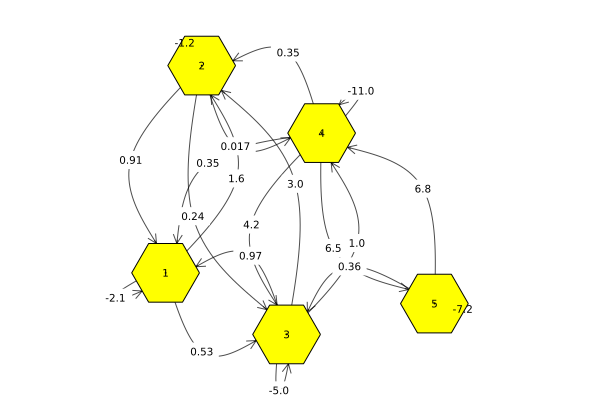

In [85]:
n = 5
edgelabel_dict = Dict()
edgelabel_mat = Array{String}(undef, n, n)
for i in 1:n
    for j in 1:n
        edgelabel_mat[i, j] = edgelabel_dict[(i, j)] = string(round(g[i,j],sigdigits=2)) 
    end
end
edgelabel_vec = edgelabel_mat[:]


graphplot(g, names=1:5, curvature_scalar=0.2,  edgelabel=edgelabel_dict, markersize = 0.5,
           linecolor = :darkgrey, markercolor = "yellow",
           linealpha = 0.7)

In [95]:
exp(g*7)

5×5 Matrix{Float64}:
 0.293555  0.59818   0.0760125  0.0168925  0.0153609
 0.293555  0.59818   0.0760125  0.0168924  0.0153608
 0.293554  0.598179  0.0760127  0.0168926  0.0153611
 0.293554  0.598178  0.0760132  0.0168931  0.0153616
 0.293553  0.598178  0.0760134  0.0168933  0.0153619